# Models with immunity

## SIR-O - a modified SIR with explicit confirmed cases
This model is modified [SIR](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIR_model): 
- **S** is *Susceptible*
- **I** is *Infectious*
- **R** is *Recovered* (and *diseased*). The model expects that this pool becomes 100% immune.
- **O** is *cOnfirmed* individuals, both hospitalized and quorantined at home with a positive test

The model utilises three parameters: $\alpha$,$\beta$ and $k$:
- $\alpha$ models the speed of infection spread,
- $\beta$ represents the speed of recovery (and deaths)
- $k$ is the reveal factor, how many infectious people are confirmed as positive.

The differential equations:<br>
$\frac{dS}{dt} = -\alpha S I$,<br>
$\frac{dI}{dt} = \alpha S I - \beta I$, <br>
$\frac{dR}{dt} = \beta I$,<br>
$\frac{dO}{dt} = k I$.


# Models without immunity

## SIRS-O - a SIR model without antigen and with explicit confirmed cases
This model is modified [SIR](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIR_model): 
- **S** is *Succeptible*
- **I** is *Infectious*
- **R** is *Recovered* (and *diseased*). While in **R** state people are immune.
- **O** is *cOnfirmed* individuals, both hospitalized and quorantined at home with a positive test

The major feature of this model is conversion of some or recovered back into succeptible.

The model utilises three parameters: $\alpha$,$\beta$ and $k$:
- $\alpha$ models the speed of infection spread,
- $\beta$ represents the speed of recovery (and deaths),
- $r_s$ is the ratio of recovered people who are susceptible again,
- $k$ is the reveal factor, how many infectious people are confirmed as positive.

The differential equations:
$\frac{dS}{dt} = -\alpha S I + r_s R$,<br>
$\frac{dI}{dt} = \alpha S I - \beta I$, <br>
$\frac{dR}{dt} = \beta I - r_s R$,<br>
$\frac{dO}{dt} = k I$.

## SIRC-O - a SIR model with carriers and with explicit confirmed cases
This model is modified [SIR](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIR_model): 
- **S** is *Succeptible*
- **I** is *Infectious*, i.e. with syptoms of the disease.
- **C** is *Carrier*, i.e. infectious, but without symptoms or actual illness.
- **R** is *Recovered* (and *diseased*). While in **R** state people are immune.
- **O** is *cOnfirmed* individuals, both hospitalized and quorantined at home with a positive test

The major feature of this model is having people carry the virus and infect others without actually being ill.

The model utilises three parameters: $\alpha$,$\beta$ and $k$:
- $\alpha$ models the speed of infection spread,
- $\beta$ represents the speed of recovery (and deaths),
- $c_s$ models efficiency of infection transmission by carriers compared to infectious.
- $i_r$ is the ratio of infectious, who recovered (became immune), and $1 - i_r$ become carriers.
- $c_r$ represents the speed of recovery of carriers.
- $k$ is the reveal factor, how many infectious people are confirmed as positive.

The differential equations:
$\frac{dS}{dt} = -\alpha S I - c_s \alpha S C$,<br>
$\frac{dI}{dt} = \alpha S I + c_s \alpha S C - \beta I$, <br>
$\frac{dR}{dt} = \beta i_r I$,<br>
$\frac{dC}{dt} = \beta (1 - i_r) I$,<br>
$\frac{dO}{dt} = k (I + C)$.



In [1]:
country  = 'India'
country2 = 'India'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numba import jit
from scipy.integrate import odeint
from datetime import datetime

%matplotlib inline

In [3]:
print("Computed on: ", datetime.now().strftime(format='%y-%m-%d %T'))

Computed on:  20-04-27 22:41:52


In [4]:
import corona

In [5]:
info = corona.CovidModel(country, country2)
print("Country: ", info.country)
print("Population: ", info.population)
print("Number of revealed cases: ", info.data[0][-1])
print("Number of deaths: ", info.data[1][-1])

Country:  India
Population:  1352617328.0
Number of revealed cases:  27890
Number of deaths:  881


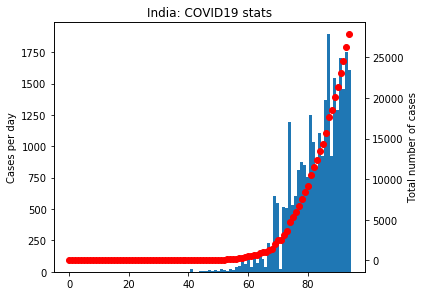

In [6]:
delta = info.data[:,1:] - info.data[:,:-1]

days = np.arange(np.shape(delta)[1])
fig, ax1 = plt.subplots()

ax1.bar(days, delta[0], width=1.0)
ax1.set_ylabel('Cases per day')

ax2 = ax1.twinx()
ax2.plot(days, info.data[0][1:], 'o', color='red')
ax2.set_ylabel('Total number of cases')
fig.tight_layout()

plt.title(info.country + ": COVID19 stats");

# Models without immunity

## Some of recovered become susceptible again

Progress: [####################] 100.0% 5.778449104950868e-07


,alpha,beta,recovered to susceptible,reveal efficiency,Infected initial,Recovered initial,R0,Precision
0,3.26,3.16,0.0164,0.00652,1455.8,4713.5,1.03,782
1,2.7,2.6,0.00964,0.0157,2277.2,2359.7,1.04,788
2,2.65,2.56,0.00883,0.0963,2612.2,2845.2,1.04,805
3,3.74,3.65,0.0489,0.00177,503.9,4538.6,1.02,808
4,3.26,3.17,0.0261,0.0163,887.3,4780.4,1.03,810
5,2.84,2.75,0.0365,0.0178,689.0,5453.2,1.03,816
6,3.17,3.08,0.0264,0.0814,908.2,5367.8,1.03,818
7,3.25,3.16,0.0432,0.0515,576.1,2570.6,1.03,819
8,2.88,2.79,0.0369,0.0292,672.1,5437.0,1.03,819
9,2.19,2.1,0.0143,0.151,1749.1,4821.8,1.04,821


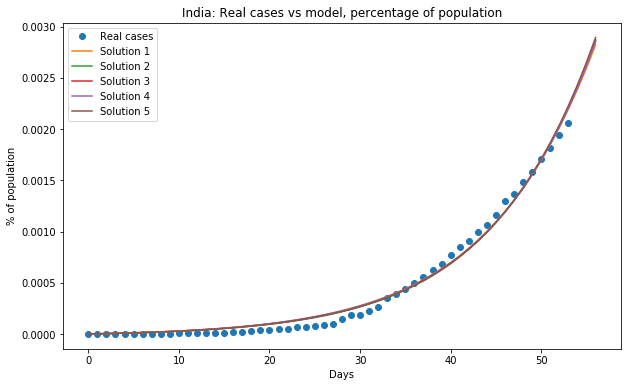

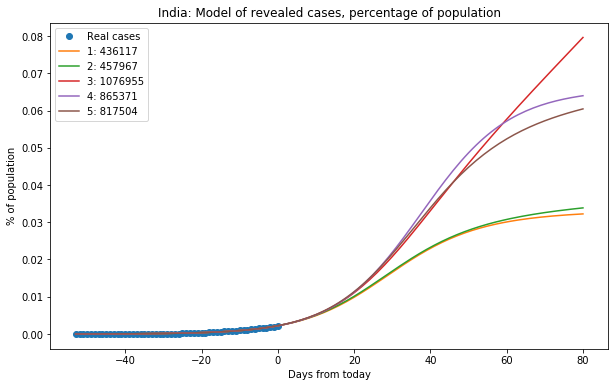

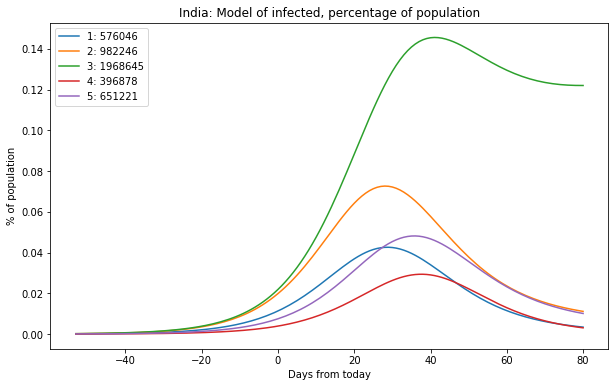

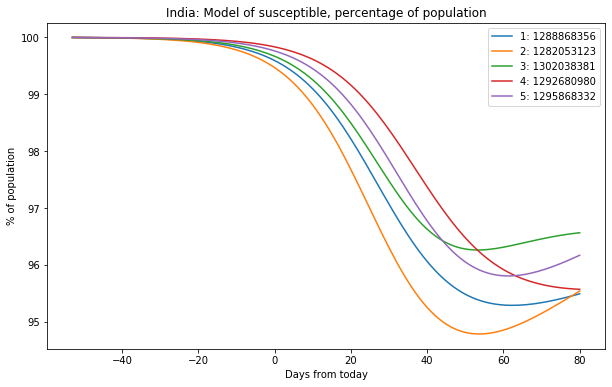

In [7]:
test_sirs = corona.CovidModel(country, country2, model='sir_so_r0')
test_sirs.run(300)

## Part of the population are symptom-less infectious carriers
Recovered posess immunity

Progress: [####################] 100.0% 2.5700881450538934e-07


,alpha,beta,carrier efficiency,infectious to recovered,carrier recovery,reveal efficiency,Initial infected,Initial carrier,Initial recovered,R0,Precision
0,2.73,3.48,0.657,0.567,2.81,0.000582,5561.8,3615.8,2421.0,0.783,348
1,2.89,3.06,0.297,0.713,2.24,0.000676,4657.4,3223.7,5591.9,0.945,363
2,3.32,3.37,0.0935,0.388,2.84,0.00049,4682.3,5271.9,5392.3,0.984,499
3,3.22,3.31,0.239,0.816,2.21,0.00201,4204.1,5398.7,5262.7,0.973,516
4,2.89,2.89,0.193,0.793,2.5,0.00147,5365.0,5293.7,4636.3,0.997,551
5,2.74,2.84,0.214,0.636,2.03,0.000345,3283.1,5185.0,3270.7,0.967,552
6,3.36,3.43,0.13,0.701,2.28,0.00176,5470.4,4396.3,4829.3,0.978,561
7,2.56,2.8,0.803,0.826,2.85,0.00228,4354.2,2080.9,4771.9,0.915,610
8,2.75,2.72,0.193,0.841,2.41,0.00135,5494.5,4899.2,3748.2,1.01,624
9,2.37,2.67,0.78,0.757,2.73,0.00118,5287.6,3897.0,4388.8,0.888,628


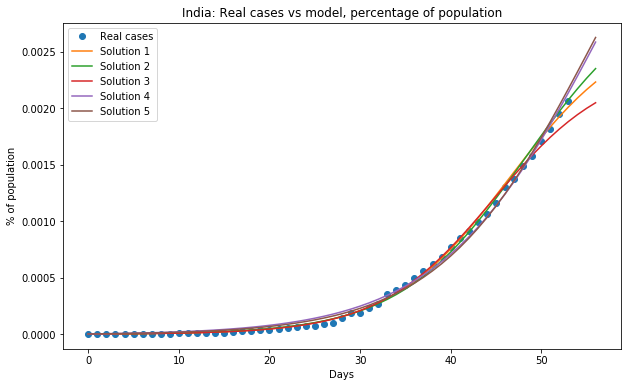

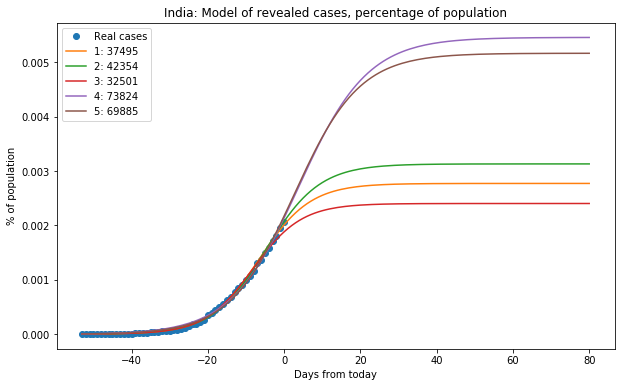

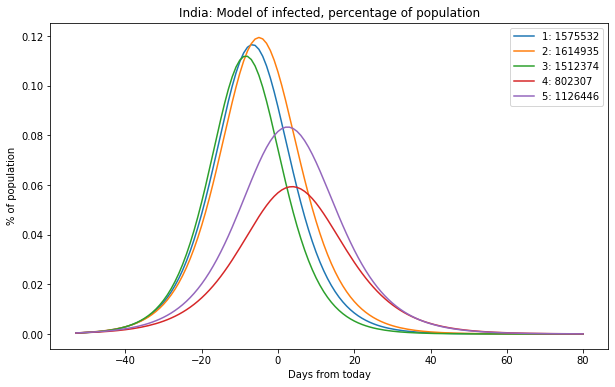

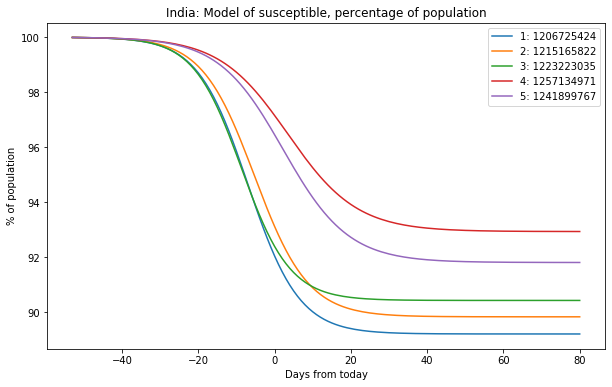

In [8]:
test_sirc = corona.CovidModel(country, country2, model='sir_co')
test_sirc.run(300)

## Part of the population are symptom-less infectious carriers, and recovered loose the immunity

Progress: [####################] 100.0% 4.140460765433519e-07


,alpha,beta,carrier efficiency,infectious to recovered,carrier recovery,recovered to susceptible,reveal efficiency,Initial infected,Initial carrier,Initial recovered,R0,Precision
0,2.1,1.81,0.0395,0.775,2.23,1.1,1.49e-05,4184.2,2233.8,2827.0,1.16,560
1,2.19,2.75,0.692,0.548,2.78,0.013,0.00559,2279.1,4722.9,3598.8,0.794,795
2,3.84,3.75,0.388,0.997,2.95,0.368,0.0142,563.2,2231.7,2460.7,1.02,820
3,2.52,2.87,0.394,0.718,1.73,0.0359,0.00866,1579.4,4356.9,1067.8,0.878,822
4,1.67,1.94,0.32,0.454,1.48,0.164,0.00335,3764.7,5323.2,3600.7,0.862,825
5,2.33,3.64,0.575,0.478,1.74,0.797,0.0113,1784.3,3515.5,270.6,0.641,826
6,2.26,2.95,0.484,0.536,1.84,0.377,0.0159,729.3,2727.6,1013.7,0.767,827
7,2.16,2.2,0.25,0.793,1.9,0.335,0.00727,2471.0,3855.9,2897.9,0.983,828
8,1.46,1.78,0.442,0.645,0.9,1.57,0.00753,1430.6,2311.6,2340.2,0.818,829
9,1.92,2.5,0.723,0.443,2.8,1.22,0.0153,950.9,3923.4,1059.7,0.767,829


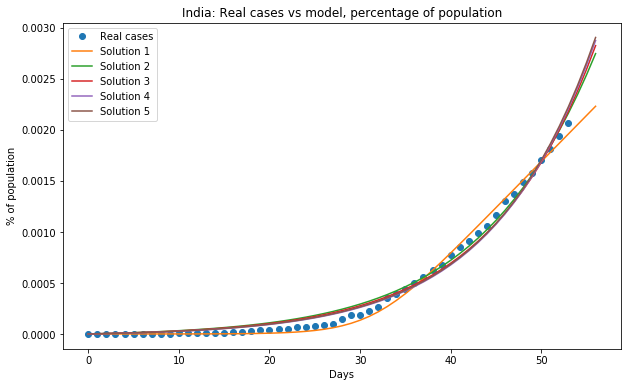

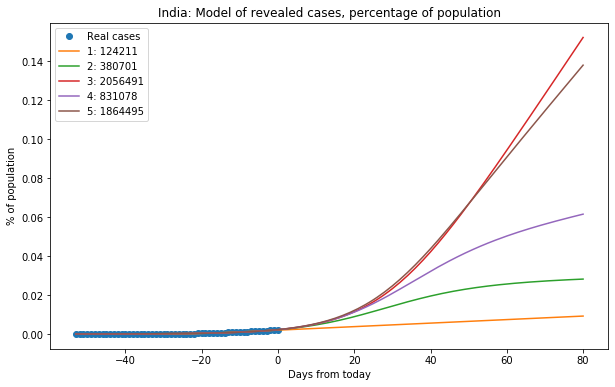

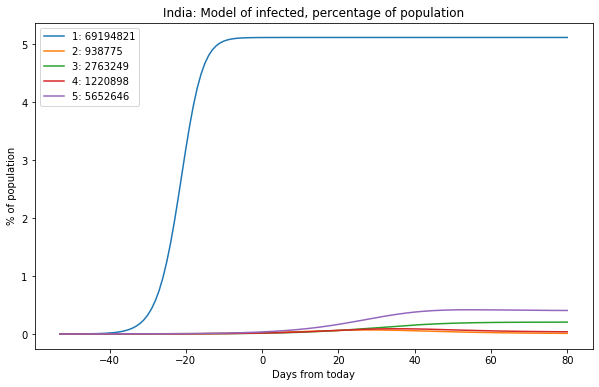

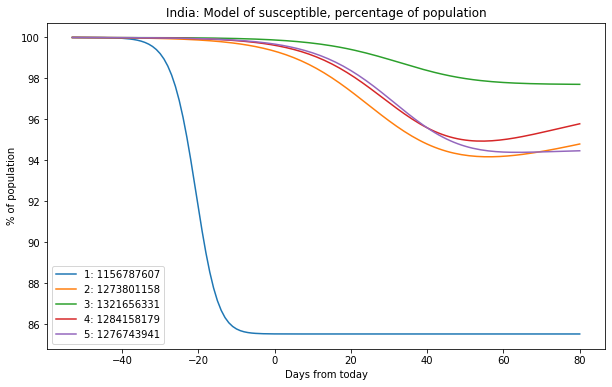

In [9]:
test_sir_sco = corona.CovidModel(country, country2, model='sir_sco')
test_sir_sco.run(300)


## Experimental model with carriers and no immunity
The major change from the previous model - difference in revealing efficiency for infectious and carriers

Progress: [####################] 100.0% 5.956967098002492e-07


,alpha,beta,carrier efficiency,infectious to recovered,carrier recovery,recovered to susceptible,Infectious reveal efficiency,Carrier reveal efficiency,Initial infected,Initial carrier,Initial recovered,R0,Precision
0,2.3,2.38,0.306,0.767,2.18,0.024,0.00852,0.0155,1705.8,3632.6,1460.4,0.965,806
1,2.3,2.29,0.602,0.962,1.64,0.106,0.00643,0.01,1920.8,4067.2,2697.6,1.01,813
2,3.09,3.44,0.0702,0.552,0.679,0.0345,0.00505,0.0175,772.8,3272.5,898.5,0.898,817
3,3.41,3.84,0.139,0.478,1.72,0.26,0.0143,0.00385,1293.7,926.1,1857.7,0.887,818
4,2.74,2.84,0.114,0.425,2.68,0.509,0.0122,0.00369,1522.7,2995.8,2548.9,0.966,825
5,3.76,3.71,0.344,0.991,1.24,1.33,0.00424,0.0202,2939.8,5489.8,2425.9,1.02,826
6,2.7,3.28,0.425,0.685,1.69,0.53,0.00874,0.00194,2570.3,4473.6,1101.8,0.825,826
7,1.91,1.92,0.112,0.503,1.98,0.179,0.00959,0.00967,1504.6,5186.0,3509.3,0.995,826
8,1.96,2.56,0.518,0.432,2.06,0.137,0.0169,0.0155,34.3,2779.9,2585.0,0.766,827
9,1.49,2.59,0.359,0.279,0.755,1.19,0.0108,0.00129,3204.0,4559.4,2105.5,0.575,829


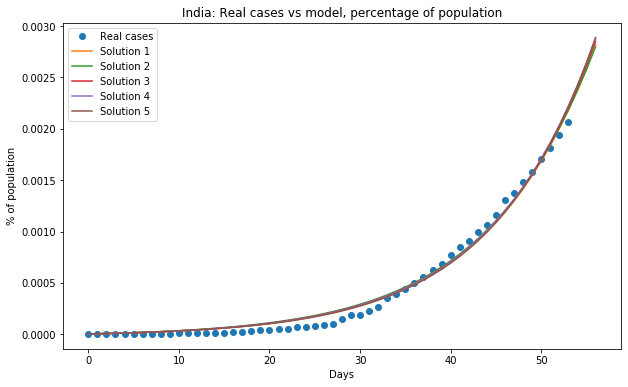

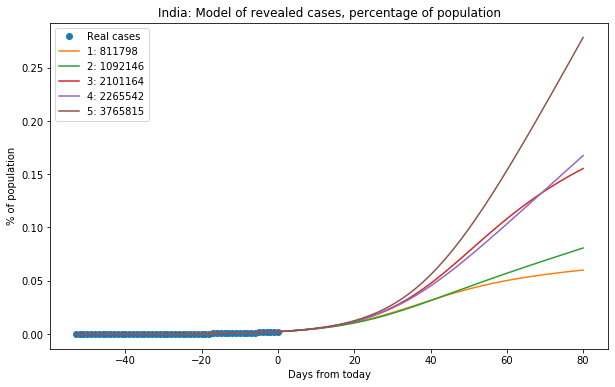

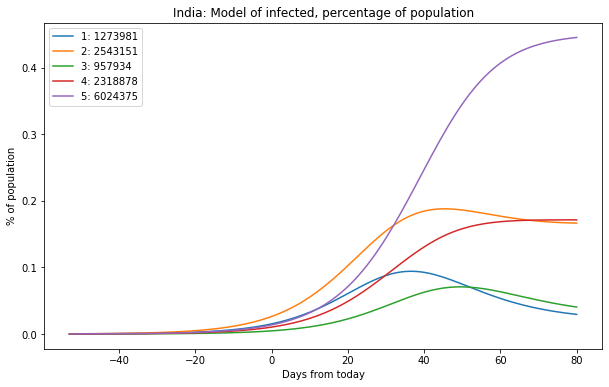

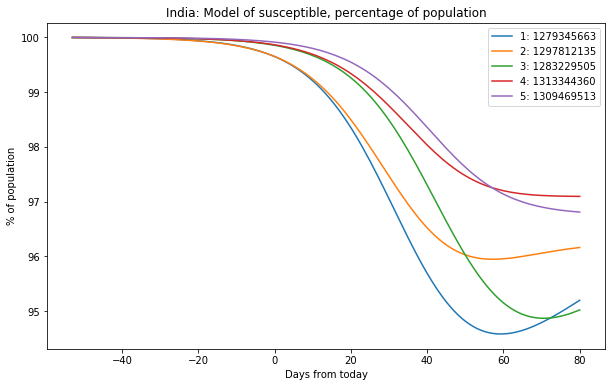

In [10]:
test_sir_sco_kc = corona.CovidModel(country, country2, model='sir_sco_kc')
test_sir_sco_kc.run(300)

## Model with incubation period and no immunity (SEIRS)

Progress: [####################] 100.0% 6.096537271063529e-07


,alpha,beta,exposed to infected,exposed to recovered,recovered to susceptible,reveal efficiency,Infected initial,Exposed initial,Recovered initial,R0,Precision
0,3.6,1.1,0.517,0.96,0.076,0.0114,2648.6,3365.1,4868.3,3.27,825
1,3.61,1.07,1.3,2.68,0.534,0.019,851.2,2923.3,2312.9,3.39,827
2,2.43,1.17,2.59,2.31,0.0978,0.00827,1247.0,4546.7,3756.4,2.08,828
3,2.16,0.984,2.45,2.42,1.24,0.00703,3841.7,1726.1,2629.0,2.2,831
4,3.81,1.58,1.47,1.83,2.17,0.0217,689.7,2794.3,1442.5,2.42,833
5,4.23,0.766,0.585,2.22,1.62,0.00769,3930.2,383.4,3895.9,5.53,837
6,3.75,1.18,1.18,2.23,0.344,0.0191,1111.2,2755.1,4337.6,3.17,837
7,3.23,1.63,2.23,1.87,0.605,0.0121,655.0,3948.8,287.7,1.98,839
8,4.41,2.74,2.58,1.36,1.32,0.0197,1569.0,650.8,4114.1,1.61,843
9,3.07,0.508,0.382,1.49,0.433,0.0055,4795.9,3310.6,1501.0,6.05,844


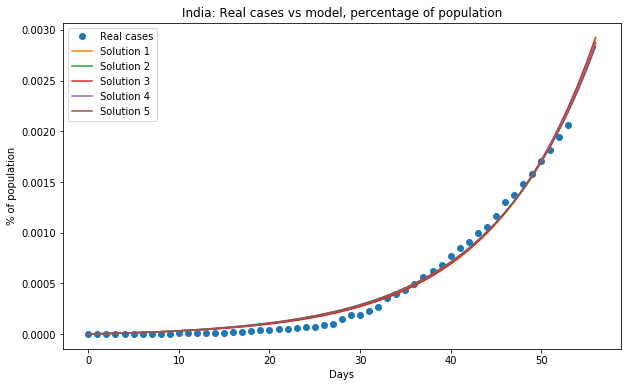

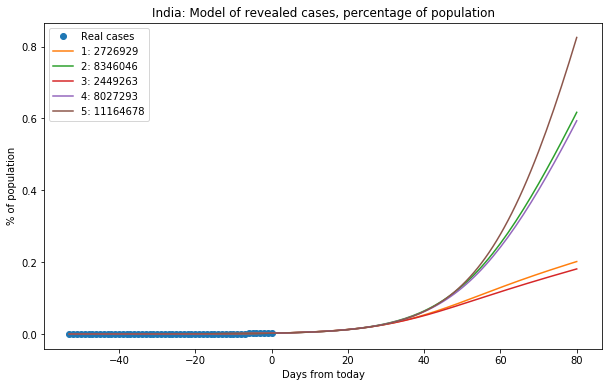

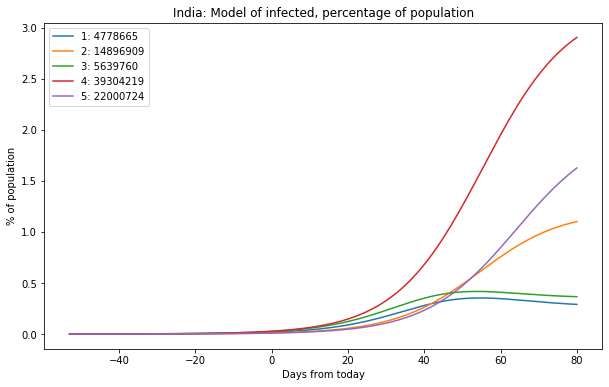

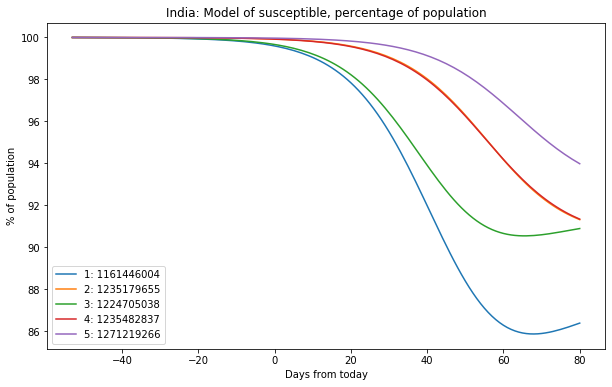

In [11]:
test_seir_so = corona.CovidModel(country, model='seir_so')
test_seir_so.run(300)

# Models with immunity

## SIR - the basic epidemiology model

Progress: [####################] 100.0% 3.5583559483197656e-07


,alpha,beta,reveal efficiency,Infected initial,Recovered initial,R0,Precision
0,2.88,2.71,0.000583,4146.4,5458.6,1.06,481
1,3.58,3.47,0.00309,5113.1,64.0,1.03,520
2,4.06,3.95,0.00501,4040.6,5186.0,1.03,634
3,2.81,2.7,0.00311,5548.8,3021.3,1.04,642
4,2.96,2.86,0.0046,3952.2,2736.3,1.04,697
5,2.55,2.39,0.000692,5392.4,1305.5,1.06,705
6,3.58,3.49,0.00813,2502.8,5600.0,1.03,724
7,3.7,3.61,0.011,2157.5,3.5,1.03,735
8,3.31,3.2,0.00484,3077.6,3208.5,1.03,741
9,2.55,2.46,0.00687,3612.9,3557.5,1.04,760


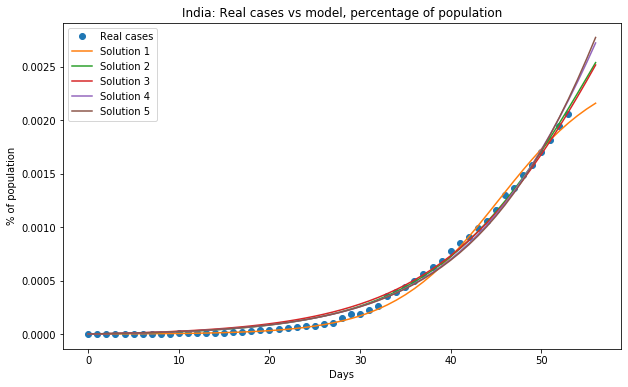

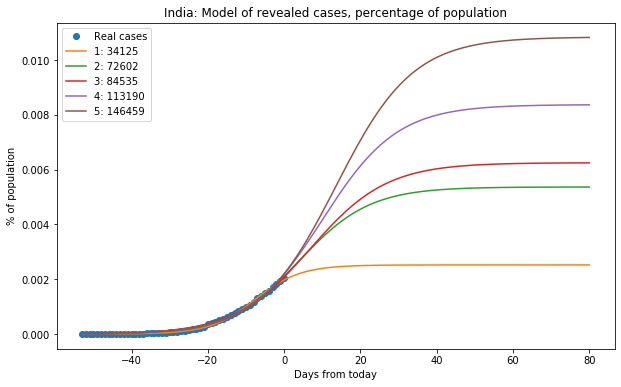

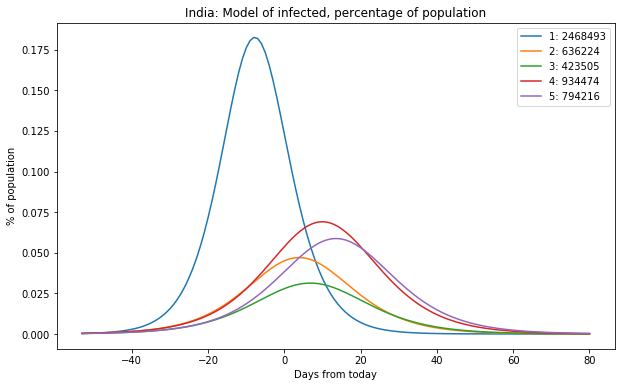

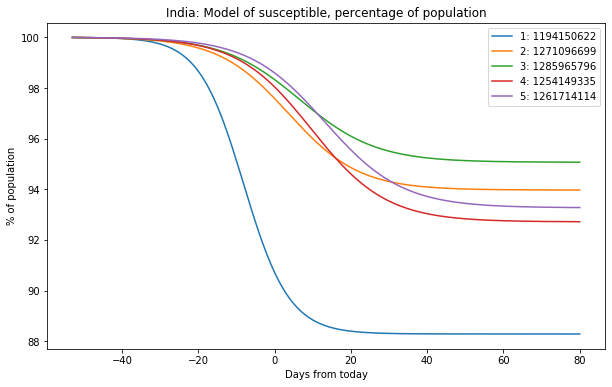

In [12]:
test_sir = corona.CovidModel(country, country2, model='sir_o_r0')

test_sir.run(500, figsize=(10, 6))

## Model with exposed (incubation period)

Progress: [####################] 100.0% 5.43434974640134e-07


,alpha,beta,exposed to infected,exposed to recovered,reveal efficiency,Infected initial,Exposed initial,Recovered initial,R0,Precision
0,4.36,1.88,1.81,2.1,0.00451,5370.1,4906.8,4347.2,2.32,735
1,4.01,2.01,2.65,2.32,0.00671,3794.6,2976.5,1156.5,2,768
2,4.86,1.93,1.73,2.36,0.0101,3219.7,1365.7,2117.3,2.52,785
3,4.02,2.75,2.86,1.1,0.0117,3446.2,280.2,3511.6,1.46,786
4,3.88,2.84,2.89,0.842,0.00771,2549.5,4241.6,2139.3,1.36,788
5,3.25,1.28,1.46,1.92,0.00513,4169.7,4509.7,2987.0,2.55,790
6,3.58,1.7,2.47,2.38,0.00502,2817.9,5126.0,988.7,2.11,797
7,4.76,2.16,1.81,1.9,0.00343,5071.2,5548.4,3413.6,2.21,799
8,3.36,1.64,2.08,1.85,0.00548,5136.9,827.4,2669.8,2.04,799
9,4.46,1.11,0.57,1.46,0.0074,3426.6,5301.0,5541.0,4.03,801


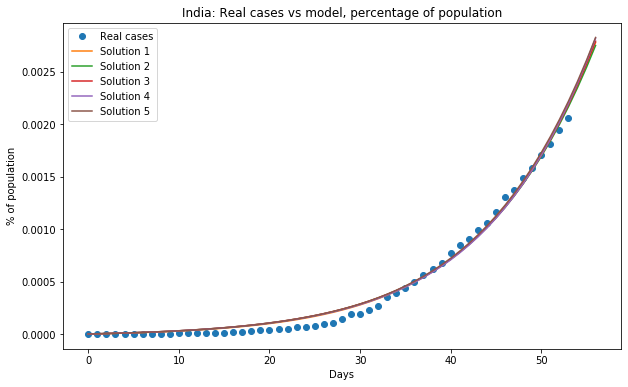

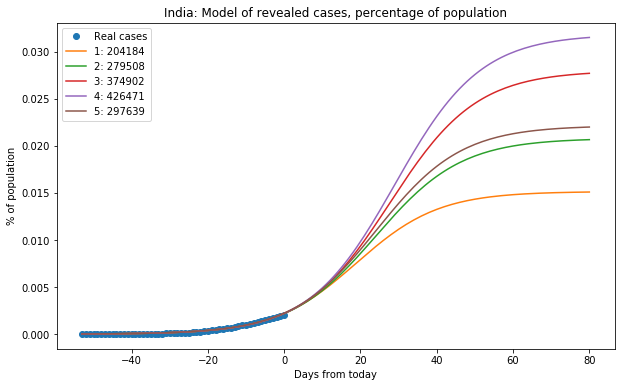

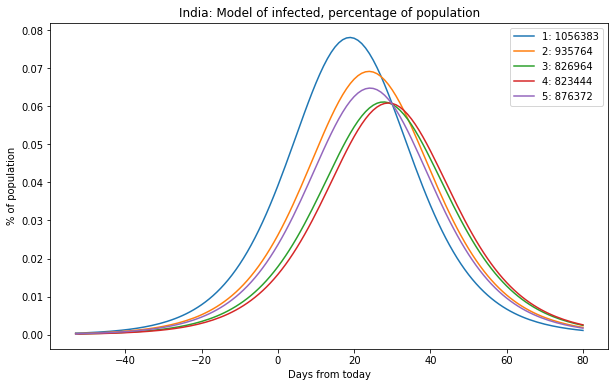

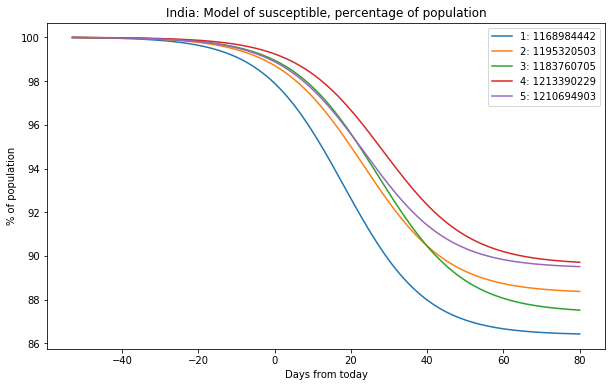

In [13]:
test_seir = corona.CovidModel(country, model='seir_o')

test_seir.run(300)